<a href="https://colab.research.google.com/github/MHusni1604/KKN-Periode-2/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# ===📦 Paket bawaan===
import os
import random
import shutil

# ===📊 Data dan visualisasi===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===🖼️ Pemrosesan gambar===
from PIL import Image
import cv2

# ===🤖 TensorFlow & Keras===
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D,
    Dense, Flatten, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras import Input
from keras.layers import TFSMLayer

# ===🧪 Utilities===
from sklearn.model_selection import train_test_split

# ===🌐 Kaggle Hub===
import kagglehub

In [4]:
path = kagglehub.dataset_download("huberthamelin/garbage-classification-labels-corrections")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/garbage-classification-labels-corrections


In [5]:
os.listdir(path)

['garbage_classification_enhanced',
 'labels_corrections.csv',
 'garbage_classification_corrected']

In [6]:
os.listdir(os.path.join(path, 'garbage_classification_enhanced'))

['metal',
 'white-glass',
 'biological',
 'paper',
 'brown-glass',
 'battery',
 'trash',
 'cardboard',
 'shoes',
 'clothes',
 'plastic',
 'green-glass']

In [7]:
folder = os.path.join(path, 'garbage_classification_enhanced')

class_names = os.listdir(folder)
print(class_names)

['metal', 'white-glass', 'biological', 'paper', 'brown-glass', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic', 'green-glass']


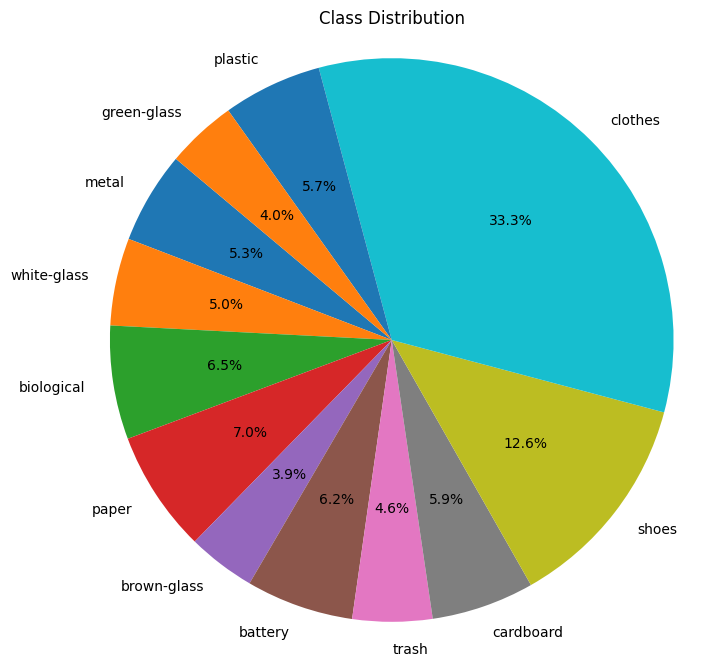

In [8]:
class_counts = []
for class_name in class_names:
    class_counts.append(len(os.listdir(os.path.join(folder, class_name))))

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

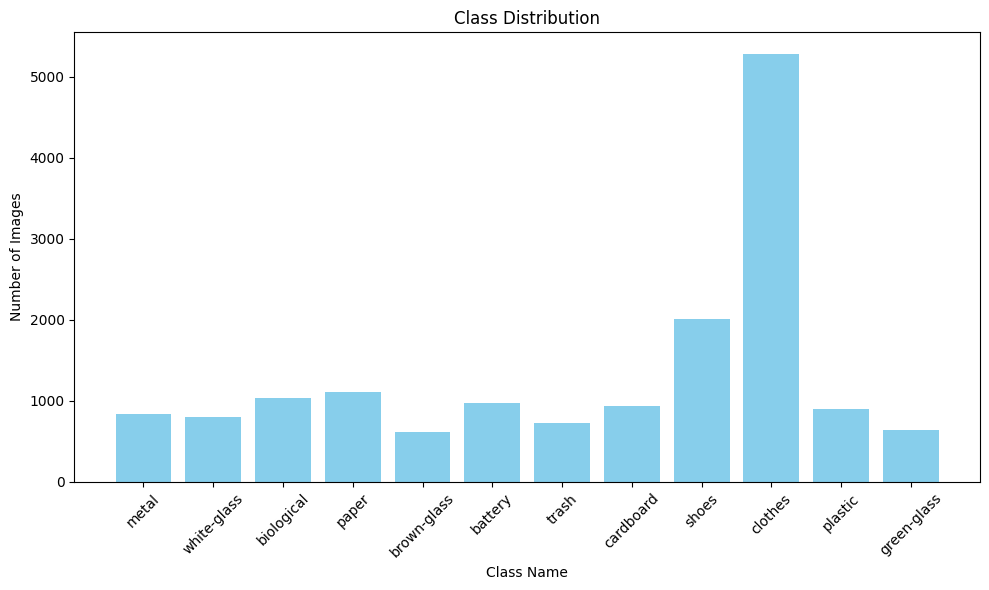

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

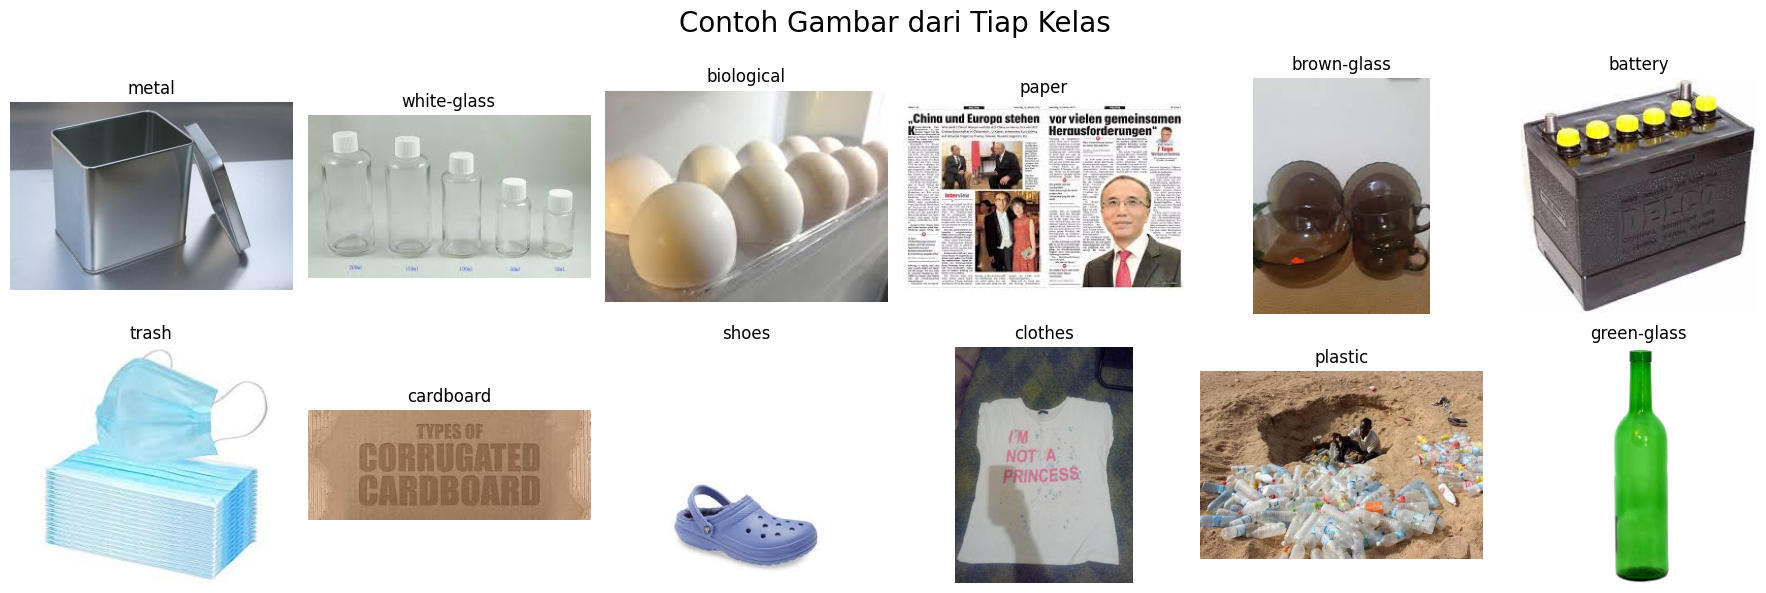

In [10]:
n_classes = len(class_names)
n_rows = 2
n_cols = int(np.ceil(n_classes / n_rows))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axs = axs.flatten()  # ubah ke 1D array supaya mudah di-loop

for ax, class_name in zip(axs, class_names):
    image_paths = []
    for folder in [folder]:
        path = os.path.join(folder, class_name)
        if os.path.exists(path):
            image_paths += [os.path.join(path, img) for img in os.listdir(path)]

    if image_paths:
        img = cv2.cvtColor(cv2.imread(random.choice(image_paths)), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(class_name)
    ax.axis('off')

plt.suptitle("Contoh Gambar dari Tiap Kelas", fontsize=20)
plt.tight_layout()
plt.show()

In [11]:
category_map = {
    'battery': 'b3',
    'biological': 'organik',
    'paper': 'daur_ulang',
    'cardboard': 'daur_ulang',
    'plastic': 'daur_ulang',
    'metal': 'daur_ulang',
    'white-glass': 'daur_ulang',
    'brown-glass': 'daur_ulang',
    'green-glass': 'daur_ulang',
    'clothes': 'residu',
    'shoes': 'residu',
    'trash': 'residu'
}

In [12]:
import os
import shutil

source_root = folder  # folder awal
target_root = 'dataset_kategori'  # folder baru setelah digabungkan

os.makedirs(target_root, exist_ok=True)

for old_class, new_class in category_map.items():
    old_path = os.path.join(source_root, old_class)
    new_path = os.path.join(target_root, new_class)
    os.makedirs(new_path, exist_ok=True)

    for file in os.listdir(old_path):
        src = os.path.join(old_path, file)
        dst = os.path.join(new_path, f"{old_class}_{file}")  # prefix agar tahu asalnya
        shutil.copy(src, dst)

In [13]:
new_class = os.listdir(os.path.join('dataset_kategori'))
print(new_class)

['b3', 'residu', 'daur_ulang', 'organik']


In [14]:
import os
import shutil
import random

# Konfigurasi
source_dir = 'dataset_kategori'
target_dir = 'dataset_split'
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

# Buat folder tujuan
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(target_dir, split, class_name), exist_ok=True)

# Bagi gambar
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    n = len(images)
    n_train = int(n * split_ratio['train'])
    n_val = int(n * split_ratio['val'])

    train_files = images[:n_train]
    val_files = images[n_train:n_train + n_val]
    test_files = images[n_train + n_val:]

    for split, files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        for file in files:
            src = os.path.join(class_path, file)
            dst = os.path.join(target_dir, split, class_name, file)
            shutil.copy(src, dst)

print("✅ Dataset berhasil dibagi menjadi train, val, dan test.")

✅ Dataset berhasil dibagi menjadi train, val, dan test.


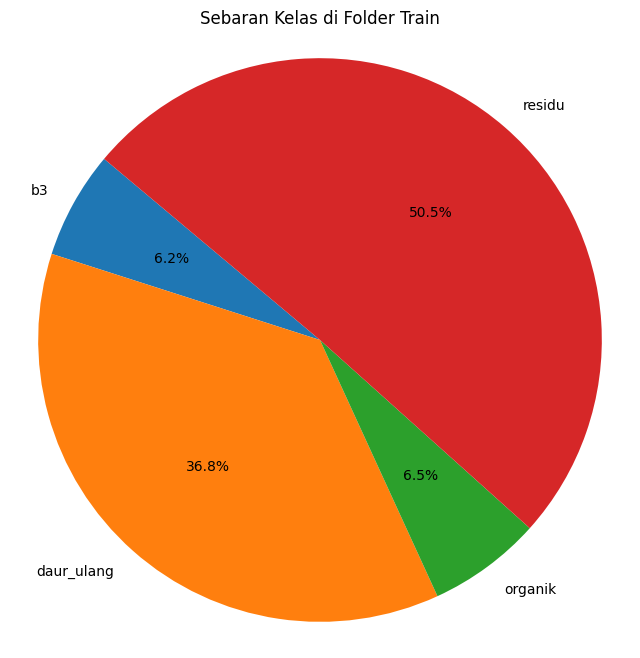

In [15]:
import os
import matplotlib.pyplot as plt

train_dir = 'dataset_split/train'

class_names = sorted(os.listdir(train_dir))  # nama folder kelas
class_counts = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts.append(count)

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Sebaran Kelas di Folder Train')
plt.axis('equal')
plt.show()

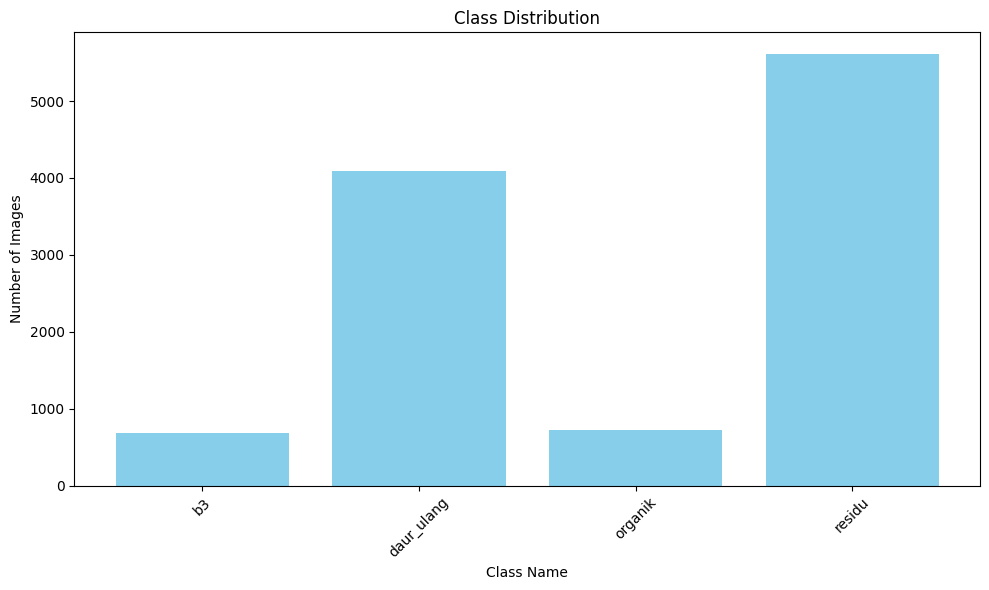

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
!pip install bing-image-downloader

In [27]:
import os
from bing_image_downloader import downloader
import shutil

# Konfigurasi folder dataset
source_folder = 'dataset_split/train'
keywords_map = {
    'b3': ['baterai bekas', 'limbah B3 rumah tangga', 'benda elektronik rusak'],
    'organik': ['sampah daun', 'sisa makanan', 'limbah dapur organik'],
    'daur_ulang': ['botol plastik bekas', 'kaleng logam', 'kertas bekas'],
    'residu': ['pakaian bekas rusak', 'sepatu rusak', 'sampah rumah tangga campur']
}

# Fungsi menghitung jumlah file dalam folder
def count_images(path):
    if not os.path.exists(path):
        return 0
    return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])

# Pastikan folder setiap kelas tersedia
for class_name in keywords_map:
    class_path = os.path.join(source_folder, class_name)
    os.makedirs(class_path, exist_ok=True)

# Tentukan jumlah target dari kelas 'residu'
residu_path = os.path.join(source_folder, 'residu')
target_count = count_images(residu_path)
print(f"🎯 Target gambar per kelas = {target_count} (mengikuti jumlah pada kelas 'residu')\n")

# Proses scraping untuk setiap kelas
for class_name, keywords in keywords_map.items():
    class_path = os.path.join(source_folder, class_name)
    current_count = count_images(class_path)
    remaining = target_count - current_count

    print(f"📂 Kelas '{class_name}': {current_count} gambar, perlu tambah {remaining}.")

    if remaining <= 0:
        continue

    keyword_index = 0
    while remaining > 0 and keyword_index < len(keywords):
        keyword = keywords[keyword_index]
        print(f"🔍 Scraping: '{keyword}' (max {min(remaining, 100)} gambar)...")

        downloader.download(keyword,
                            limit=min(remaining, 100),
                            output_dir='temp_download',
                            adult_filter_off=True,
                            force_replace=False,
                            timeout=60,
                            verbose=False)

        # Bing mengubah spasi → underscore dan lowercase
        safe_keyword = keyword.lower().replace(' ', '_')
        download_path = os.path.join('temp_download', safe_keyword)

        if os.path.exists(download_path):
            files = os.listdir(download_path)
            print(f"📥 {len(files)} file ditemukan di '{download_path}'")

            for f in files:
                if not f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    print(f"⚠️ Lewati non-gambar: {f}")
                    continue

                src = os.path.join(download_path, f)
                dst = os.path.join(class_path, f"{class_name}_{current_count}.jpg")

                try:
                    if os.path.isfile(src):
                        print(f"🔄 Memindahkan: {src} → {dst}")
                        shutil.move(src, dst)
                        current_count += 1
                        remaining -= 1
                    else:
                        print(f"⚠️ Bukan file: {src}")
                except Exception as e:
                    print(f"❌ Gagal memindahkan {src} → {e}")

            # Hapus folder keyword setelah selesai
            shutil.rmtree(download_path)
        else:
            print(f"⚠️ Folder tidak ditemukan: {download_path}")

        keyword_index += 1

# Hapus folder sementara jika kosong
if os.path.exists('temp_download') and not os.listdir('temp_download'):
    os.rmdir('temp_download')

print("\n✅ Scraping selesai. Semua kelas diusahakan memiliki jumlah gambar sesuai kelas 'residu'.")


🎯 Target gambar per kelas = 5612 (mengikuti jumlah pada kelas 'residu')

📂 Kelas 'b3': 955 gambar, perlu tambah 4657.
🔍 Scraping: 'baterai bekas' (max 100 gambar)...
[%] Downloading Images to /content/temp_download/baterai bekas
[!] Issue getting: https://s1.bukalapak.com/img/1433397062/w-1000/Baterai_Batre_Bekas_Laptop_6_CELL.jpg
[!] Error:: HTTP Error 404: Not Found
[!] Issue getting: https://umumsekali.com/wp-content/uploads/2019/10/Baterai2BBekas2BJangan2BDibuang2BSembarangan.jpg
[!] Error:: <urlopen error timed out>
[!] Issue getting: https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEjkTDWet-WEnsnebgQU5Vr6FDPP9upsVswQkwM3sRqRS_vXNP6motncjrkoFZxO8OhMLMQWMtmldlMHYOMWbMzxq83PJfHlh8sJyvXrfxqBI9HGUt8U3iNlQFlsQS7cfg0YKTcaGPxqiA2yTr8Bc8JmKjeJrIe0jo5HLboxv7kAu1vNl_LXJOMUmF7J0Mdp/s1600/Aki Bekas3.jpg
[!] Error:: URL can't contain control characters. '/img/b/R29vZ2xl/AVvXsEjkTDWet-WEnsnebgQU5Vr6FDPP9upsVswQkwM3sRqRS_vXNP6motncjrkoFZxO8OhMLMQWMtmldlMHYOMWbMzxq83PJfHlh8sJyvXrfxqBI9HG

In [31]:
import os

train_dir = '/content/temp_download'

class_counts = {}
total_count = 0

for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        class_counts[class_name] = count
        total_count += count

# Tampilkan hasil
print("📊 Jumlah gambar per kelas di TRAIN:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} gambar")

print(f"\n🧮 Total gambar di set TRAIN: {total_count} gambar")


📊 Jumlah gambar per kelas di TRAIN:
  baterai bekas: 106 gambar
  benda elektronik rusak: 112 gambar
  botol plastik bekas: 109 gambar
  kaleng logam: 108 gambar
  kertas bekas: 100 gambar
  limbah B3 rumah tangga: 150 gambar
  limbah dapur organik: 134 gambar
  sampah daun: 116 gambar
  sisa makanan: 124 gambar

🧮 Total gambar di set TRAIN: 1059 gambar


In [21]:
base_dir = 'dataset_split'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 11929 images belonging to 4 classes.
Found 2385 images belonging to 4 classes.
Found 2378 images belonging to 4 classes.


In [22]:
class StopTrainingAtAccuracy(Callback):
    def __init__(self, acc_threshold=0.95, val_acc_threshold=0.95):
        super(StopTrainingAtAccuracy, self).__init__()
        self.acc_threshold = acc_threshold
        self.val_acc_threshold = val_acc_threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if acc is not None and val_acc is not None:
            if acc >= self.acc_threshold and val_acc >= self.val_acc_threshold:
                print(f"\n Target tercapai! Akurasi dan val_akurasi >= {self.acc_threshold * 100:.0f}%")
                self.model.stop_training = True

In [23]:
model = Sequential([
    InputLayer(input_shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [24]:
callback = [
    StopTrainingAtAccuracy(),
    ModelCheckpoint('model_checkpoint.keras', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
]

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=callback,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
181/373 ━━━━━━━━━━━━━━━━━━━━ 6:31 2s/step - accuracy: 0.5080 - loss: 1.0985

KeyboardInterrupt: 